In [ ]:
from custom_models.ddpm import MyDDPM, UNet
import torch
import torch.nn as nn
from utils import load_medMNIST_data


In [3]:
dataloader, dataset = load_medMNIST_data()

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Image size: torch.Size([3, 28, 28])
Label size: torch.Size([1])
Label values: {0, 1, 2, 3, 4, 5, 6, 7}


In [4]:
# get image size from the dataset
channels, dim_1, dim_2 = dataloader.dataset[0][0].shape

print(f"Channels: {channels}")
print(f"Dim 1: {dim_1}")
print(f"Dim 2: {dim_2}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Channels: 3
Dim 1: 28
Dim 2: 28


In [ ]:
# ********** Training parameters **********
lr = 1e-4  
n_epochs = 501  

# ********** DDPM parameters **********

# Defining model
n_steps, min_beta, max_beta = 500, 10 ** -4, 0.02  # Originally used by the authors of the paper
ddpm = MyDDPM(
    UNet(n_steps=n_steps, in_channels=channels), 
    n_steps=n_steps, 
    min_beta=min_beta, 
    max_beta=max_beta, 
    device=device, 
    image_chw=(channels, dim_1, dim_2)
)

In [ ]:
from custom_models.ddpm import generate_new_images, show_images
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def save_generated_images(images, epoch):
    # Create a grid with WHITE padding (pad_value=1.0)
    grid = vutils.make_grid(images, nrow=7, padding=2, normalize=True, pad_value=1.0)
    
    # Save the image
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")

    for epoch in range(n_epochs):
        epoch_loss = 0.0

        for batch in loader:
            x0 = batch[0].to(device)
            n = len(x0)

            # Ensure proper tensor shapes
            assert x0.shape[1:
                            ] == ddpm.image_chw, f"Shape mismatch: {x0.shape[1:]} vs {ddpm.image_chw}"

            eta = torch.randn_like(x0)
            t = torch.randint(0, ddpm.n_steps, (n,)).to(device)

            noisy_imgs = ddpm(x0, t, eta)
            eta_theta = ddpm.backward(noisy_imgs, t)

            loss = mse(eta, eta_theta)

            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        
        if epoch % 25 == 0:
            with torch.no_grad():
                samples = generate_new_images(ddpm, n_samples=4, device=device)
                show_images(samples, f"Epoch {epoch}")

        # Save samples every 100 epochs
        if epoch % 100 == 0:
            with torch.no_grad():
                generated = generate_new_images(
                    ddpm,
                    option=2,
                    n_samples=49,  # change the number of samples as needed
                    device=device,
                )
                show_images(generated, f"Generated Samples at Epoch {epoch}")
                save_generated_images(generated, epoch)
                
                
                

        print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save({
                'model_state_dict': ddpm.state_dict(),
                'n_steps': ddpm.n_steps,
                'image_chw': ddpm.image_chw,
                'epoch': epoch,
                'loss': epoch_loss
            }, store_path)

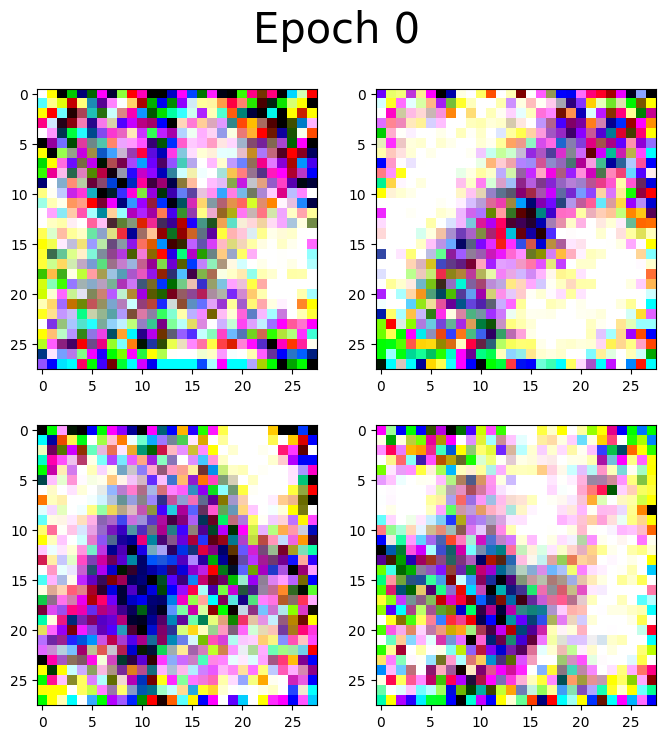

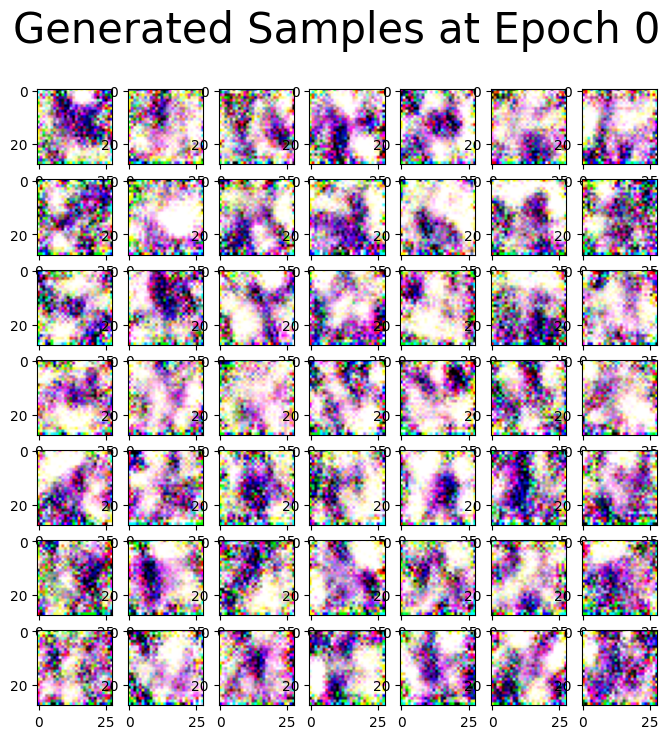

Epoch 0: Loss = 0.6818
Epoch 1: Loss = 0.2521
Epoch 2: Loss = 0.1827
Epoch 3: Loss = 0.1512
Epoch 4: Loss = 0.1317
Epoch 5: Loss = 0.1187
Epoch 6: Loss = 0.1088
Epoch 7: Loss = 0.0998
Epoch 8: Loss = 0.0939
Epoch 9: Loss = 0.0896
Epoch 10: Loss = 0.0878
Epoch 11: Loss = 0.0841
Epoch 12: Loss = 0.0790
Epoch 13: Loss = 0.0797
Epoch 14: Loss = 0.0763
Epoch 15: Loss = 0.0723
Epoch 16: Loss = 0.0715
Epoch 17: Loss = 0.0703
Epoch 18: Loss = 0.0735
Epoch 19: Loss = 0.0678
Epoch 20: Loss = 0.0671
Epoch 21: Loss = 0.0660
Epoch 22: Loss = 0.0653
Epoch 23: Loss = 0.0648
Epoch 24: Loss = 0.0640


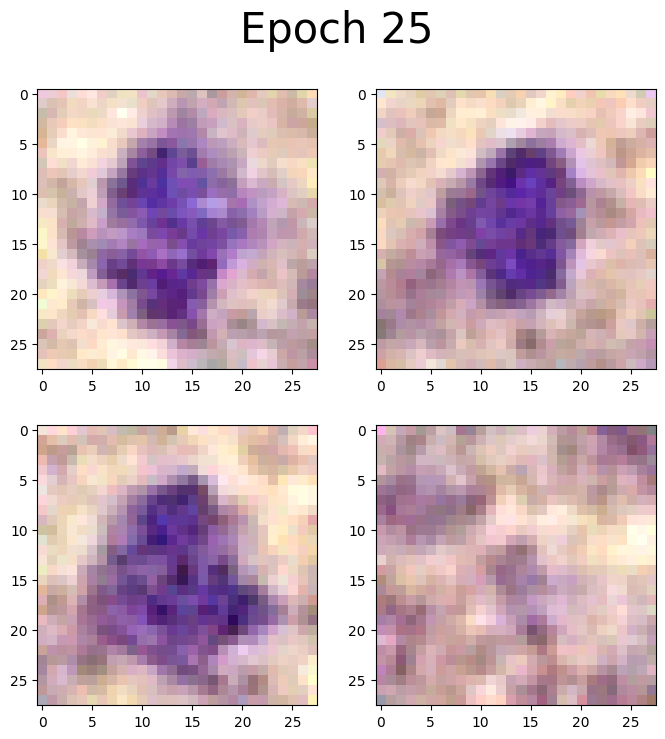

Epoch 25: Loss = 0.0642
Epoch 26: Loss = 0.0620
Epoch 27: Loss = 0.0616
Epoch 28: Loss = 0.0625
Epoch 29: Loss = 0.0598
Epoch 30: Loss = 0.0597
Epoch 31: Loss = 0.0608
Epoch 32: Loss = 0.0584
Epoch 33: Loss = 0.0595
Epoch 34: Loss = 0.0584
Epoch 35: Loss = 0.0573
Epoch 36: Loss = 0.0571
Epoch 37: Loss = 0.0570
Epoch 38: Loss = 0.0563
Epoch 39: Loss = 0.0556
Epoch 40: Loss = 0.0543
Epoch 41: Loss = 0.0540
Epoch 42: Loss = 0.0545
Epoch 43: Loss = 0.0543
Epoch 44: Loss = 0.0542
Epoch 45: Loss = 0.0529
Epoch 46: Loss = 0.0522
Epoch 47: Loss = 0.0533
Epoch 48: Loss = 0.0532
Epoch 49: Loss = 0.0525


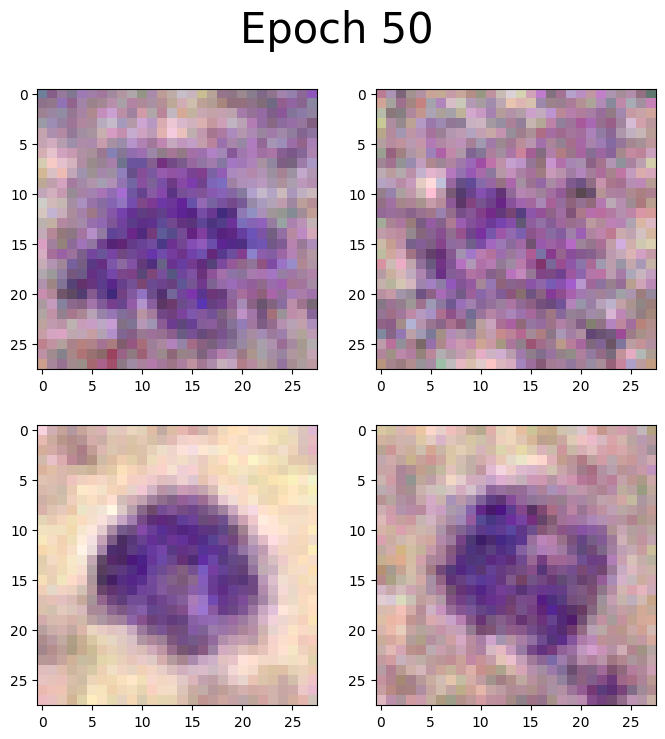

Epoch 50: Loss = 0.0518
Epoch 51: Loss = 0.0514
Epoch 52: Loss = 0.0519
Epoch 53: Loss = 0.0525
Epoch 54: Loss = 0.0530
Epoch 55: Loss = 0.0500
Epoch 56: Loss = 0.0499
Epoch 57: Loss = 0.0492
Epoch 58: Loss = 0.0499
Epoch 59: Loss = 0.0497
Epoch 60: Loss = 0.0499
Epoch 61: Loss = 0.0493
Epoch 62: Loss = 0.0490
Epoch 63: Loss = 0.0486
Epoch 64: Loss = 0.0494
Epoch 65: Loss = 0.0481
Epoch 66: Loss = 0.0508
Epoch 67: Loss = 0.0498
Epoch 68: Loss = 0.0474
Epoch 69: Loss = 0.0484
Epoch 70: Loss = 0.0473
Epoch 71: Loss = 0.0484
Epoch 72: Loss = 0.0483
Epoch 73: Loss = 0.0470
Epoch 74: Loss = 0.0464


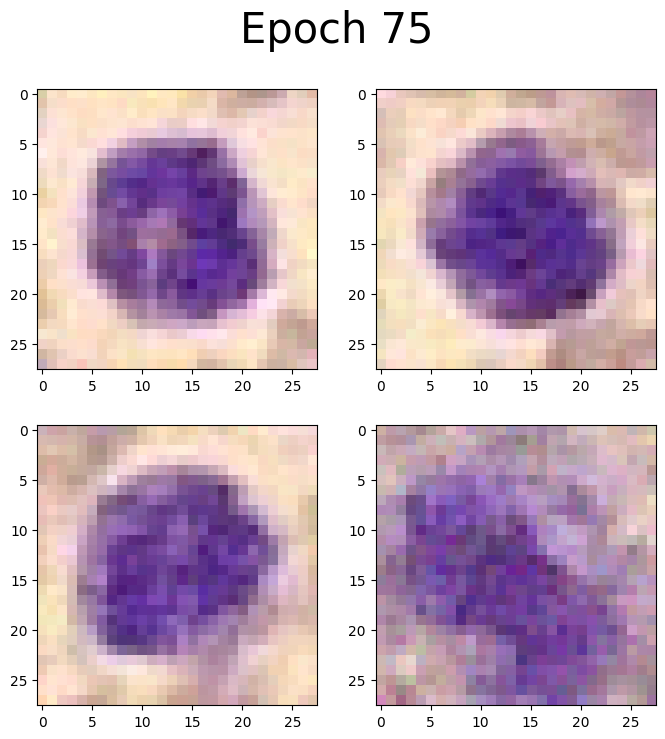

Epoch 75: Loss = 0.0479
Epoch 76: Loss = 0.0475
Epoch 77: Loss = 0.0472
Epoch 78: Loss = 0.0470
Epoch 79: Loss = 0.0459
Epoch 80: Loss = 0.0449
Epoch 81: Loss = 0.0452
Epoch 82: Loss = 0.0471
Epoch 83: Loss = 0.0453
Epoch 84: Loss = 0.0467
Epoch 85: Loss = 0.0447
Epoch 86: Loss = 0.0448
Epoch 87: Loss = 0.0453
Epoch 88: Loss = 0.0454
Epoch 89: Loss = 0.0448
Epoch 90: Loss = 0.0450
Epoch 91: Loss = 0.0450
Epoch 92: Loss = 0.0453
Epoch 93: Loss = 0.0443
Epoch 94: Loss = 0.0449
Epoch 95: Loss = 0.0439
Epoch 96: Loss = 0.0443
Epoch 97: Loss = 0.0441
Epoch 98: Loss = 0.0435
Epoch 99: Loss = 0.0438


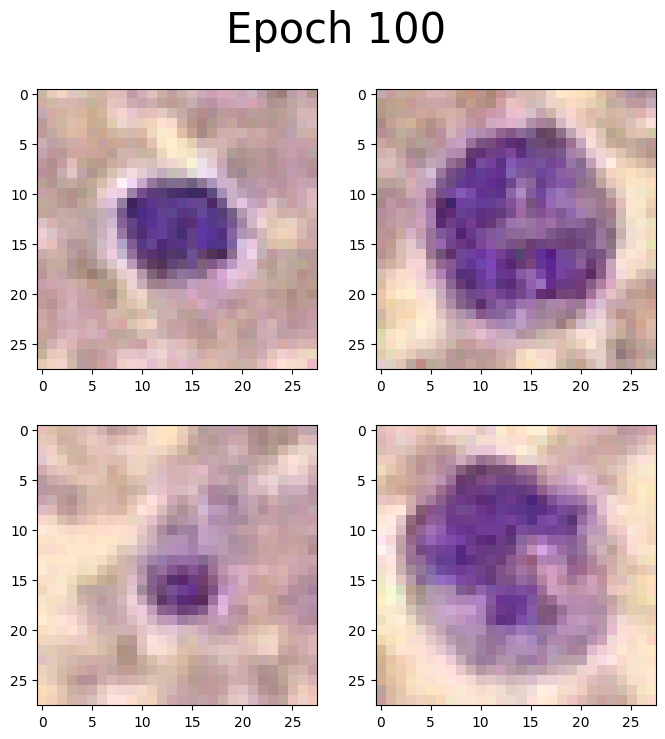

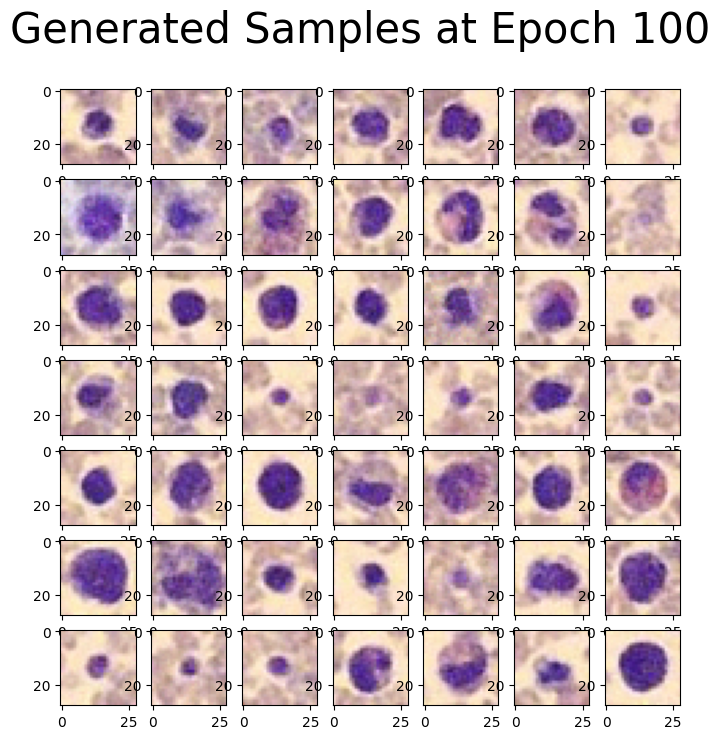

Epoch 100: Loss = 0.0443
Epoch 101: Loss = 0.0441
Epoch 102: Loss = 0.0431
Epoch 103: Loss = 0.0432
Epoch 104: Loss = 0.0465
Epoch 105: Loss = 0.0442
Epoch 106: Loss = 0.0440
Epoch 107: Loss = 0.0431
Epoch 108: Loss = 0.0439
Epoch 109: Loss = 0.0433
Epoch 110: Loss = 0.0431
Epoch 111: Loss = 0.0411
Epoch 112: Loss = 0.0416
Epoch 113: Loss = 0.0423
Epoch 114: Loss = 0.0421
Epoch 115: Loss = 0.0420
Epoch 116: Loss = 0.0418
Epoch 117: Loss = 0.0432
Epoch 118: Loss = 0.0431
Epoch 119: Loss = 0.0438
Epoch 120: Loss = 0.0419
Epoch 121: Loss = 0.0426
Epoch 122: Loss = 0.0419
Epoch 123: Loss = 0.0428
Epoch 124: Loss = 0.0418


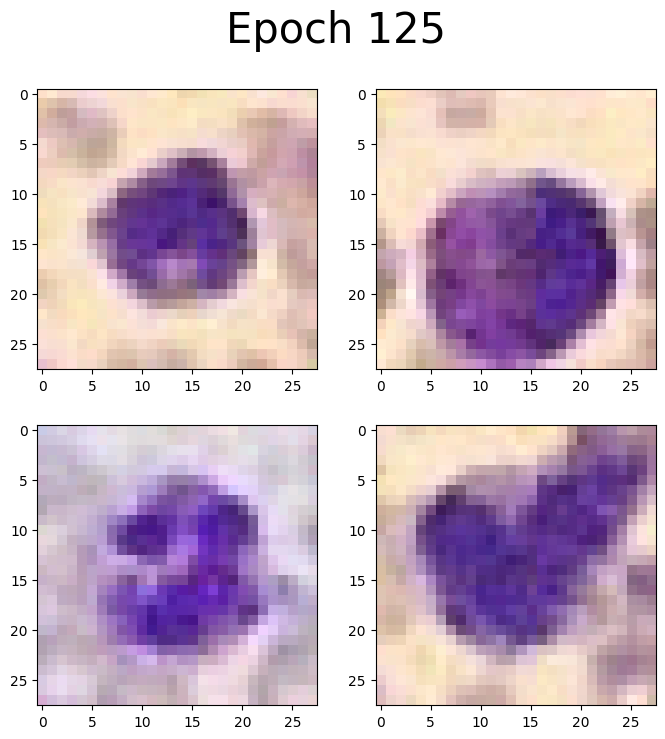

Epoch 125: Loss = 0.0412
Epoch 126: Loss = 0.0413
Epoch 127: Loss = 0.0421
Epoch 128: Loss = 0.0407
Epoch 129: Loss = 0.0414
Epoch 130: Loss = 0.0421
Epoch 131: Loss = 0.0417
Epoch 132: Loss = 0.0406
Epoch 133: Loss = 0.0405
Epoch 134: Loss = 0.0412
Epoch 135: Loss = 0.0411
Epoch 136: Loss = 0.0407
Epoch 137: Loss = 0.0407
Epoch 138: Loss = 0.0412
Epoch 139: Loss = 0.0414
Epoch 140: Loss = 0.0404
Epoch 141: Loss = 0.0401
Epoch 142: Loss = 0.0404
Epoch 143: Loss = 0.0411
Epoch 144: Loss = 0.0419
Epoch 145: Loss = 0.0406
Epoch 146: Loss = 0.0399
Epoch 147: Loss = 0.0400
Epoch 148: Loss = 0.0410
Epoch 149: Loss = 0.0385


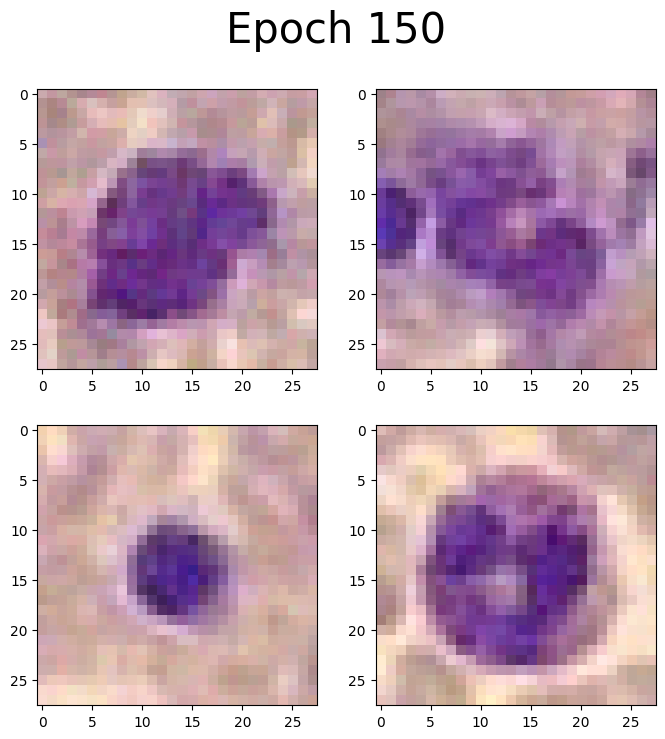

Epoch 150: Loss = 0.0398
Epoch 151: Loss = 0.0397
Epoch 152: Loss = 0.0396
Epoch 153: Loss = 0.0393
Epoch 154: Loss = 0.0396
Epoch 155: Loss = 0.0381
Epoch 156: Loss = 0.0385
Epoch 157: Loss = 0.0395
Epoch 158: Loss = 0.0378
Epoch 159: Loss = 0.0393
Epoch 160: Loss = 0.0389
Epoch 161: Loss = 0.0384
Epoch 162: Loss = 0.0389
Epoch 163: Loss = 0.0388
Epoch 164: Loss = 0.0377
Epoch 165: Loss = 0.0386
Epoch 166: Loss = 0.0393
Epoch 167: Loss = 0.0387
Epoch 168: Loss = 0.0380
Epoch 169: Loss = 0.0399
Epoch 170: Loss = 0.0382
Epoch 171: Loss = 0.0393
Epoch 172: Loss = 0.0383
Epoch 173: Loss = 0.0380
Epoch 174: Loss = 0.0381


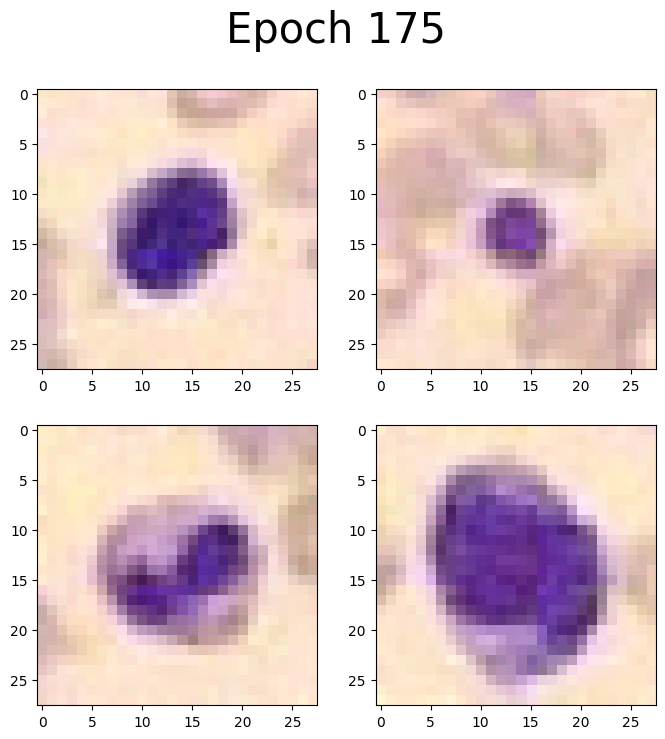

Epoch 175: Loss = 0.0377
Epoch 176: Loss = 0.0396
Epoch 177: Loss = 0.0382
Epoch 178: Loss = 0.0384
Epoch 179: Loss = 0.0384
Epoch 180: Loss = 0.0379
Epoch 181: Loss = 0.0390
Epoch 182: Loss = 0.0386
Epoch 183: Loss = 0.0380
Epoch 184: Loss = 0.0387
Epoch 185: Loss = 0.0365
Epoch 186: Loss = 0.0372
Epoch 187: Loss = 0.0380
Epoch 188: Loss = 0.0363
Epoch 189: Loss = 0.0371
Epoch 190: Loss = 0.0370
Epoch 191: Loss = 0.0371
Epoch 192: Loss = 0.0367
Epoch 193: Loss = 0.0375
Epoch 194: Loss = 0.0372
Epoch 195: Loss = 0.0369
Epoch 196: Loss = 0.0373
Epoch 197: Loss = 0.0374
Epoch 198: Loss = 0.0365
Epoch 199: Loss = 0.0367


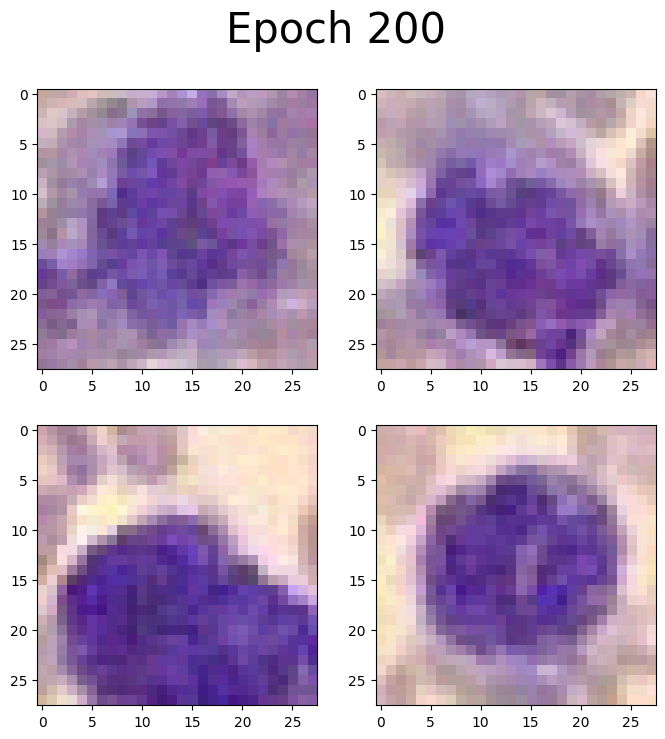

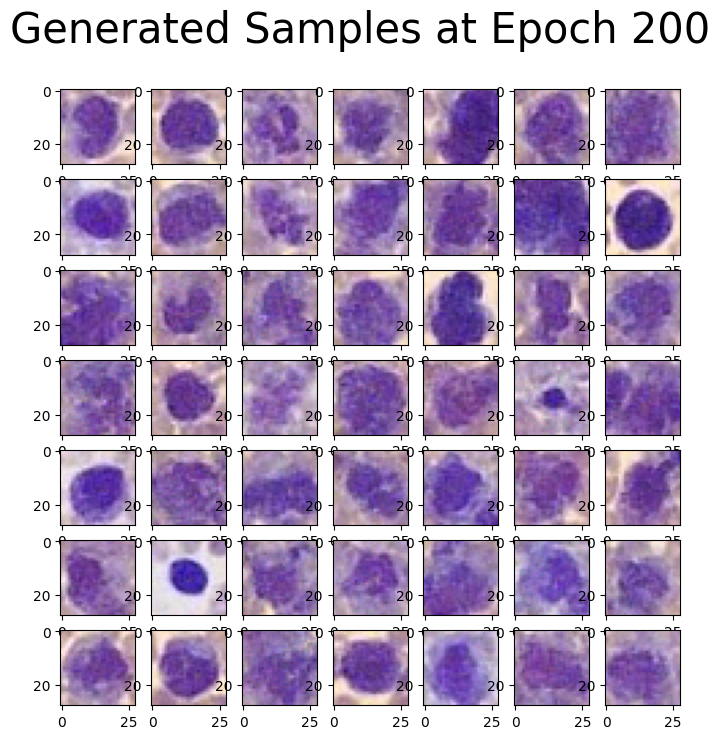

Epoch 200: Loss = 0.0379
Epoch 201: Loss = 0.0367
Epoch 202: Loss = 0.0364
Epoch 203: Loss = 0.0371
Epoch 204: Loss = 0.0373
Epoch 205: Loss = 0.0360
Epoch 206: Loss = 0.0369
Epoch 207: Loss = 0.0372
Epoch 208: Loss = 0.0359
Epoch 209: Loss = 0.0360
Epoch 210: Loss = 0.0363
Epoch 211: Loss = 0.0365
Epoch 212: Loss = 0.0361
Epoch 213: Loss = 0.0364
Epoch 214: Loss = 0.0366
Epoch 215: Loss = 0.0364
Epoch 216: Loss = 0.0369
Epoch 217: Loss = 0.0370
Epoch 218: Loss = 0.0363
Epoch 219: Loss = 0.0363
Epoch 220: Loss = 0.0359
Epoch 221: Loss = 0.0371
Epoch 222: Loss = 0.0357
Epoch 223: Loss = 0.0361
Epoch 224: Loss = 0.0360


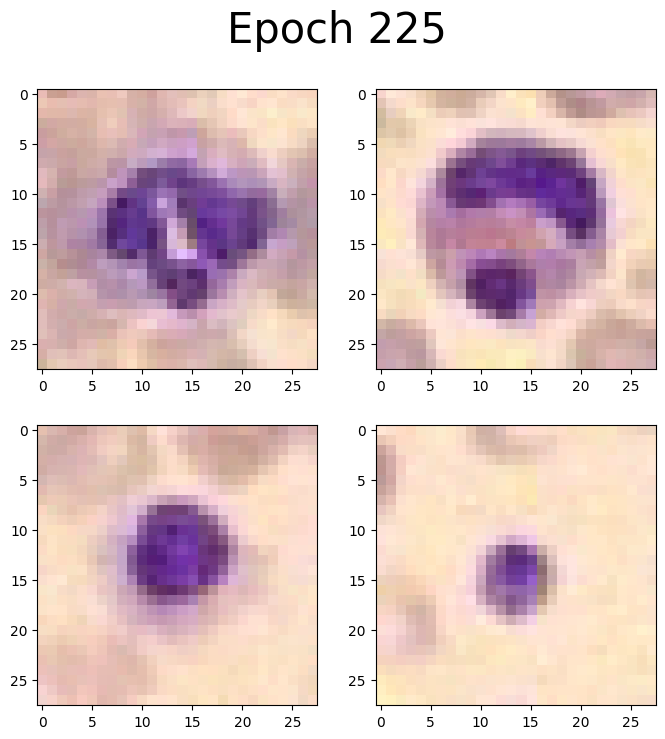

Epoch 225: Loss = 0.0357
Epoch 226: Loss = 0.0352
Epoch 227: Loss = 0.0350
Epoch 228: Loss = 0.0362
Epoch 229: Loss = 0.0355
Epoch 230: Loss = 0.0350
Epoch 231: Loss = 0.0368
Epoch 232: Loss = 0.0357
Epoch 233: Loss = 0.0349
Epoch 234: Loss = 0.0361
Epoch 235: Loss = 0.0365
Epoch 236: Loss = 0.0358
Epoch 237: Loss = 0.0353
Epoch 238: Loss = 0.0350
Epoch 239: Loss = 0.0354
Epoch 240: Loss = 0.0356
Epoch 241: Loss = 0.0344
Epoch 242: Loss = 0.0361
Epoch 243: Loss = 0.0355
Epoch 244: Loss = 0.0353
Epoch 245: Loss = 0.0362
Epoch 246: Loss = 0.0352
Epoch 247: Loss = 0.0349
Epoch 248: Loss = 0.0355
Epoch 249: Loss = 0.0352


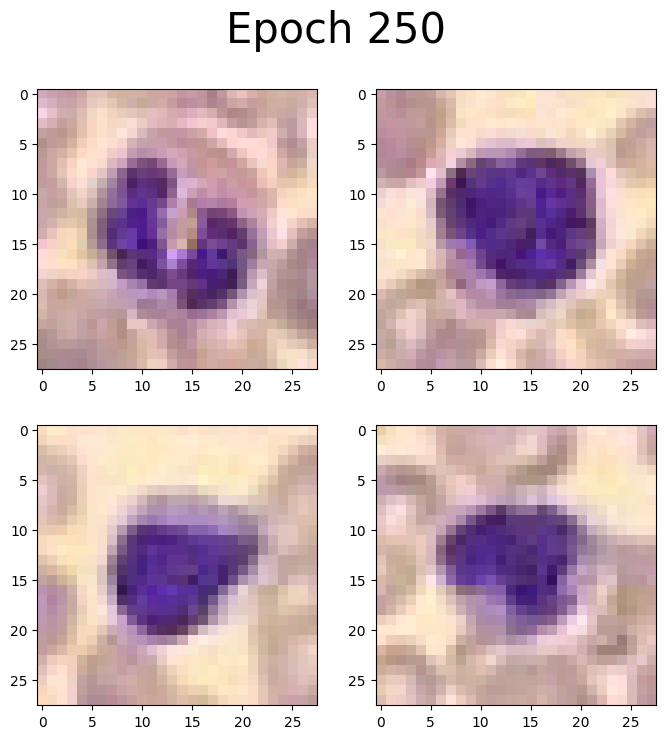

Epoch 250: Loss = 0.0351
Epoch 251: Loss = 0.0358
Epoch 252: Loss = 0.0345
Epoch 253: Loss = 0.0343
Epoch 254: Loss = 0.0354
Epoch 255: Loss = 0.0348
Epoch 256: Loss = 0.0339
Epoch 257: Loss = 0.0345
Epoch 258: Loss = 0.0340
Epoch 259: Loss = 0.0348
Epoch 260: Loss = 0.0349
Epoch 261: Loss = 0.0348
Epoch 262: Loss = 0.0337
Epoch 263: Loss = 0.0339
Epoch 264: Loss = 0.0346
Epoch 265: Loss = 0.0346
Epoch 266: Loss = 0.0354
Epoch 267: Loss = 0.0346
Epoch 268: Loss = 0.0344
Epoch 269: Loss = 0.0341
Epoch 270: Loss = 0.0350
Epoch 271: Loss = 0.0338
Epoch 272: Loss = 0.0346
Epoch 273: Loss = 0.0343
Epoch 274: Loss = 0.0345


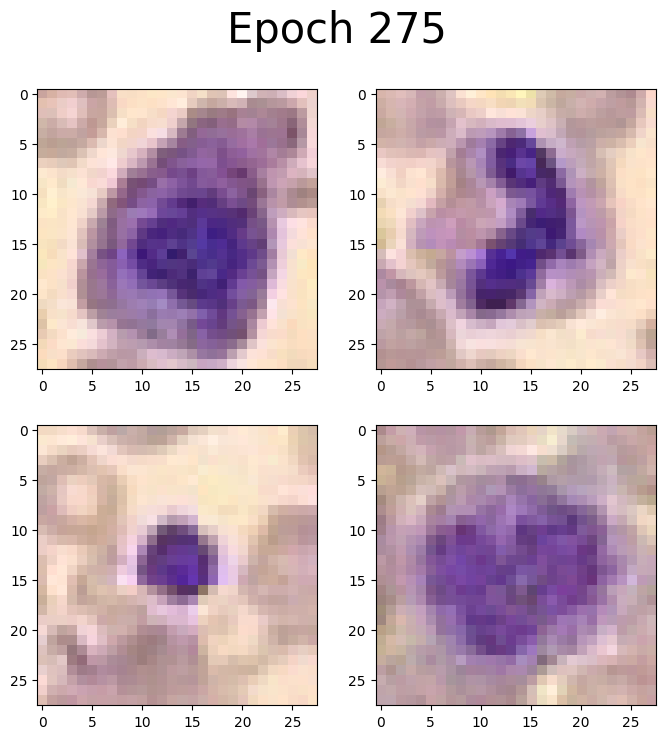

Epoch 275: Loss = 0.0348
Epoch 276: Loss = 0.0340
Epoch 277: Loss = 0.0339
Epoch 278: Loss = 0.0340
Epoch 279: Loss = 0.0342
Epoch 280: Loss = 0.0341
Epoch 281: Loss = 0.0347
Epoch 282: Loss = 0.0336
Epoch 283: Loss = 0.0343
Epoch 284: Loss = 0.0343
Epoch 285: Loss = 0.0345
Epoch 286: Loss = 0.0339
Epoch 287: Loss = 0.0344
Epoch 288: Loss = 0.0334
Epoch 289: Loss = 0.0341
Epoch 290: Loss = 0.0339
Epoch 291: Loss = 0.0341
Epoch 292: Loss = 0.0341
Epoch 293: Loss = 0.0336
Epoch 294: Loss = 0.0336
Epoch 295: Loss = 0.0336
Epoch 296: Loss = 0.0338
Epoch 297: Loss = 0.0339
Epoch 298: Loss = 0.0338
Epoch 299: Loss = 0.0334


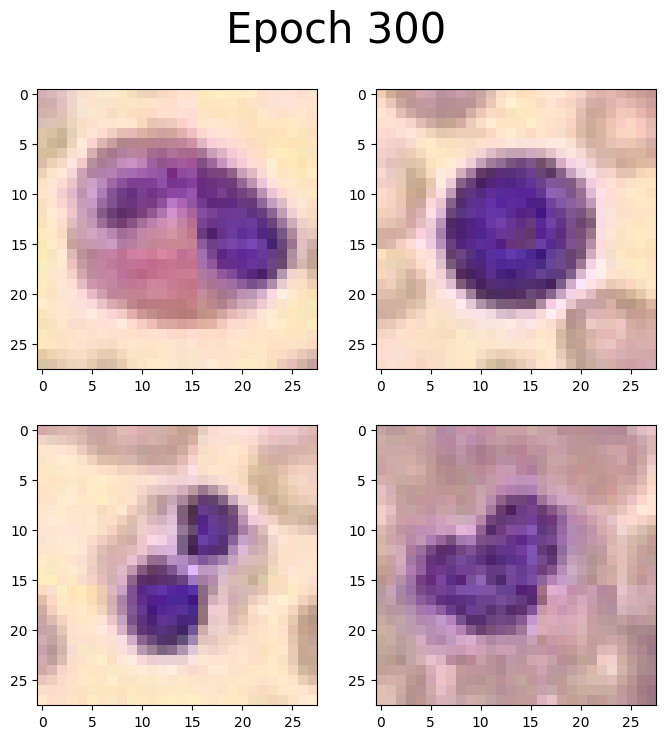

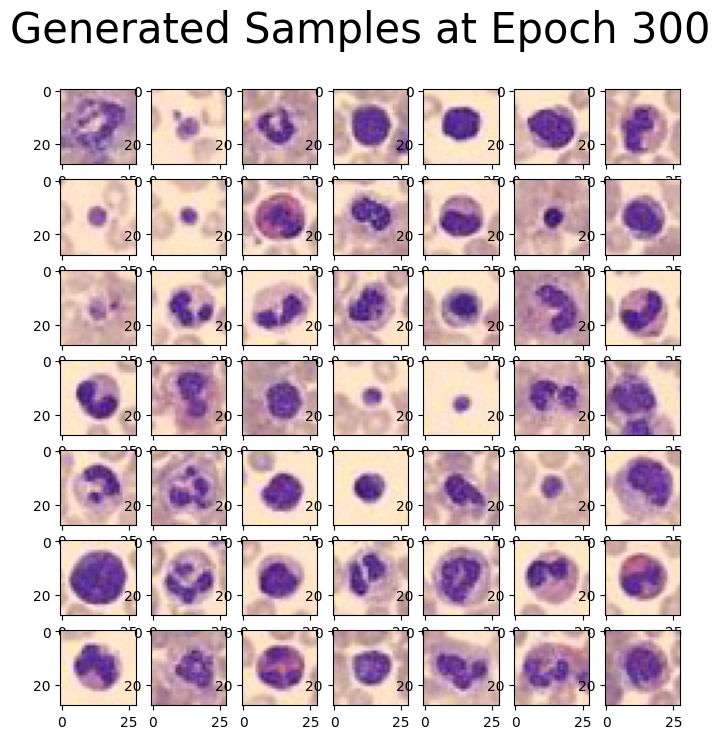

Epoch 300: Loss = 0.0331
Epoch 301: Loss = 0.0336
Epoch 302: Loss = 0.0332
Epoch 303: Loss = 0.0326
Epoch 304: Loss = 0.0347
Epoch 305: Loss = 0.0331
Epoch 306: Loss = 0.0332
Epoch 307: Loss = 0.0345
Epoch 308: Loss = 0.0337
Epoch 309: Loss = 0.0332
Epoch 310: Loss = 0.0327
Epoch 311: Loss = 0.0332
Epoch 312: Loss = 0.0332
Epoch 313: Loss = 0.0337
Epoch 314: Loss = 0.0334
Epoch 315: Loss = 0.0329
Epoch 316: Loss = 0.0332
Epoch 317: Loss = 0.0332
Epoch 318: Loss = 0.0338
Epoch 319: Loss = 0.0334
Epoch 320: Loss = 0.0329
Epoch 321: Loss = 0.0329
Epoch 322: Loss = 0.0332
Epoch 323: Loss = 0.0334
Epoch 324: Loss = 0.0339


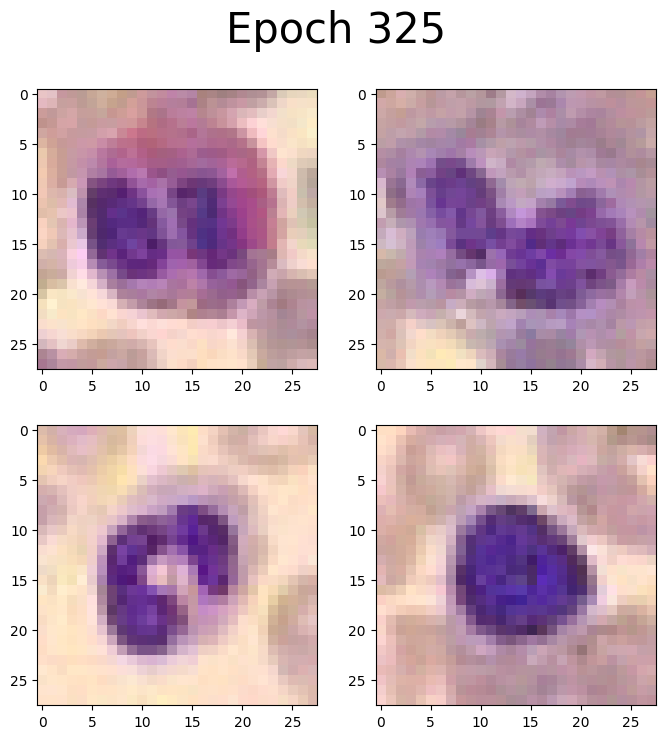

Epoch 325: Loss = 0.0324
Epoch 326: Loss = 0.0333
Epoch 327: Loss = 0.0327
Epoch 328: Loss = 0.0331
Epoch 329: Loss = 0.0334
Epoch 330: Loss = 0.0336
Epoch 331: Loss = 0.0326
Epoch 332: Loss = 0.0334
Epoch 333: Loss = 0.0336
Epoch 334: Loss = 0.0334
Epoch 335: Loss = 0.0332
Epoch 336: Loss = 0.0323
Epoch 337: Loss = 0.0325
Epoch 338: Loss = 0.0326
Epoch 339: Loss = 0.0329
Epoch 340: Loss = 0.0321
Epoch 341: Loss = 0.0333
Epoch 342: Loss = 0.0323
Epoch 343: Loss = 0.0331
Epoch 344: Loss = 0.0326
Epoch 345: Loss = 0.0331
Epoch 346: Loss = 0.0323
Epoch 347: Loss = 0.0325
Epoch 348: Loss = 0.0332
Epoch 349: Loss = 0.0320


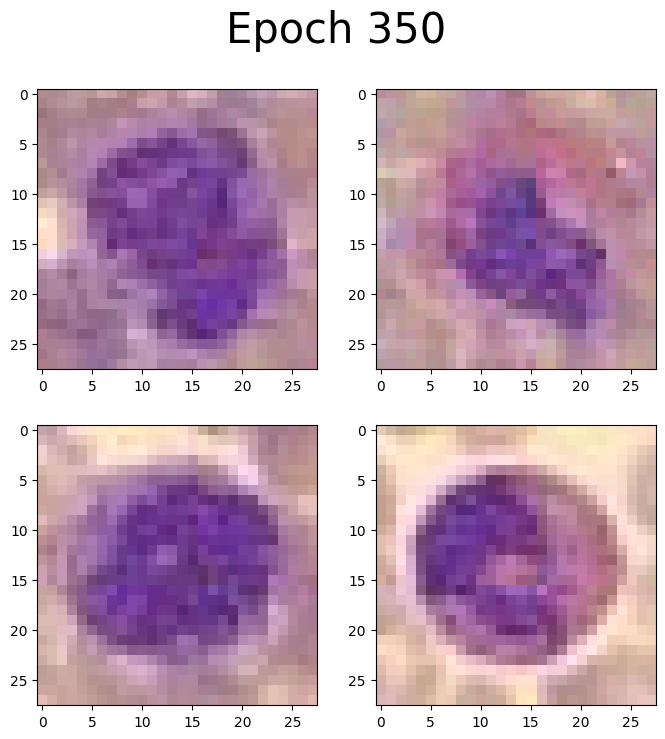

Epoch 350: Loss = 0.0330
Epoch 351: Loss = 0.0328
Epoch 352: Loss = 0.0327
Epoch 353: Loss = 0.0330
Epoch 354: Loss = 0.0328
Epoch 355: Loss = 0.0331
Epoch 356: Loss = 0.0317
Epoch 357: Loss = 0.0324
Epoch 358: Loss = 0.0322
Epoch 359: Loss = 0.0316
Epoch 360: Loss = 0.0311
Epoch 361: Loss = 0.0318
Epoch 362: Loss = 0.0321
Epoch 363: Loss = 0.0314
Epoch 364: Loss = 0.0330
Epoch 365: Loss = 0.0330
Epoch 366: Loss = 0.0323
Epoch 367: Loss = 0.0322
Epoch 368: Loss = 0.0326
Epoch 369: Loss = 0.0318
Epoch 370: Loss = 0.0323
Epoch 371: Loss = 0.0334
Epoch 372: Loss = 0.0313
Epoch 373: Loss = 0.0324
Epoch 374: Loss = 0.0316


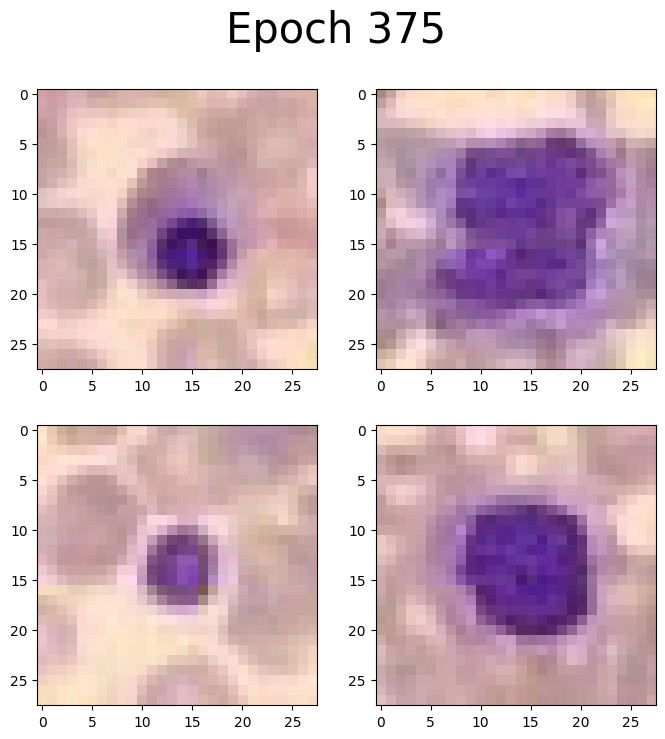

Epoch 375: Loss = 0.0325
Epoch 376: Loss = 0.0319
Epoch 377: Loss = 0.0320
Epoch 378: Loss = 0.0325
Epoch 379: Loss = 0.0312
Epoch 380: Loss = 0.0320
Epoch 381: Loss = 0.0317
Epoch 382: Loss = 0.0320
Epoch 383: Loss = 0.0318
Epoch 384: Loss = 0.0322
Epoch 385: Loss = 0.0324
Epoch 386: Loss = 0.0327
Epoch 387: Loss = 0.0313
Epoch 388: Loss = 0.0314
Epoch 389: Loss = 0.0320
Epoch 390: Loss = 0.0311
Epoch 391: Loss = 0.0316
Epoch 392: Loss = 0.0319
Epoch 393: Loss = 0.0323
Epoch 394: Loss = 0.0324
Epoch 395: Loss = 0.0313
Epoch 396: Loss = 0.0313
Epoch 397: Loss = 0.0313
Epoch 398: Loss = 0.0321
Epoch 399: Loss = 0.0328


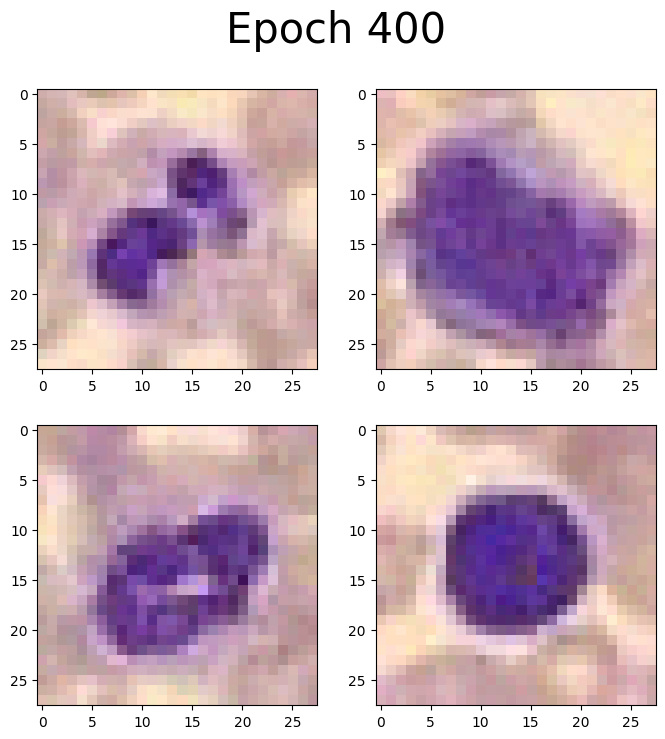

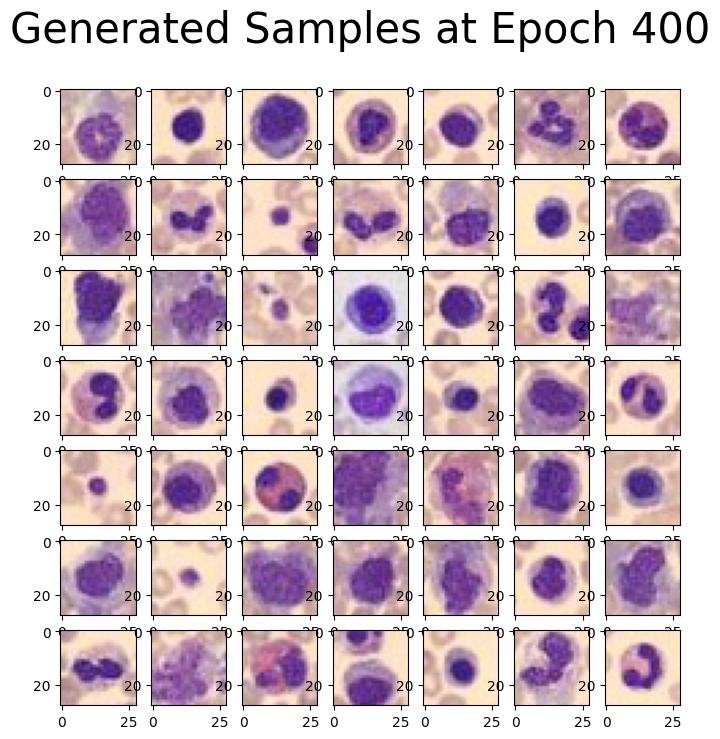

Epoch 400: Loss = 0.0320
Epoch 401: Loss = 0.0321
Epoch 402: Loss = 0.0319
Epoch 403: Loss = 0.0320
Epoch 404: Loss = 0.0317
Epoch 405: Loss = 0.0311
Epoch 406: Loss = 0.0315
Epoch 407: Loss = 0.0317
Epoch 408: Loss = 0.0311
Epoch 409: Loss = 0.0314
Epoch 410: Loss = 0.0311
Epoch 411: Loss = 0.0310
Epoch 412: Loss = 0.0324
Epoch 413: Loss = 0.0321
Epoch 414: Loss = 0.0309
Epoch 415: Loss = 0.0313
Epoch 416: Loss = 0.0312
Epoch 417: Loss = 0.0315
Epoch 418: Loss = 0.0330
Epoch 419: Loss = 0.0307
Epoch 420: Loss = 0.0310
Epoch 421: Loss = 0.0319
Epoch 422: Loss = 0.0307
Epoch 423: Loss = 0.0309
Epoch 424: Loss = 0.0320


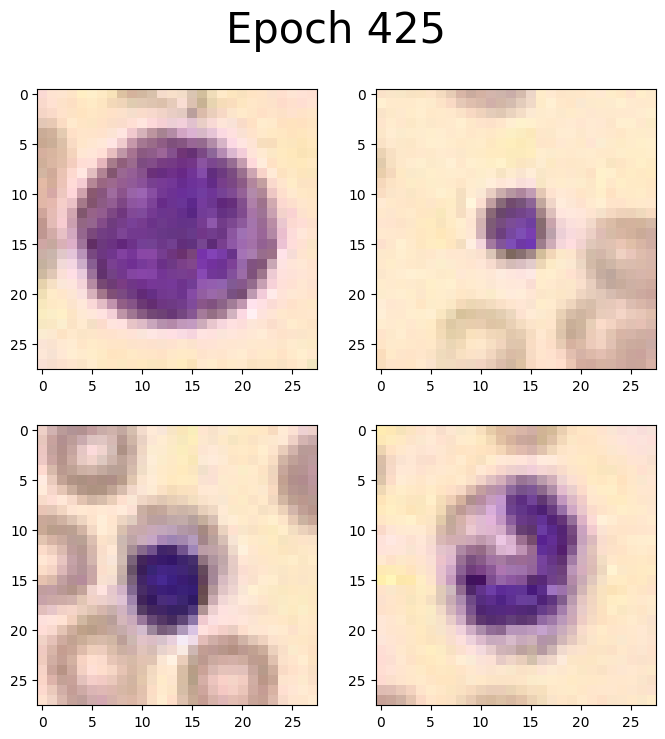

Epoch 425: Loss = 0.0304
Epoch 426: Loss = 0.0320
Epoch 427: Loss = 0.0313
Epoch 428: Loss = 0.0305
Epoch 429: Loss = 0.0316
Epoch 430: Loss = 0.0309
Epoch 431: Loss = 0.0321
Epoch 432: Loss = 0.0303
Epoch 433: Loss = 0.0308
Epoch 434: Loss = 0.0317
Epoch 435: Loss = 0.0315
Epoch 436: Loss = 0.0314
Epoch 437: Loss = 0.0313
Epoch 438: Loss = 0.0313
Epoch 439: Loss = 0.0303
Epoch 440: Loss = 0.0313
Epoch 441: Loss = 0.0313
Epoch 442: Loss = 0.0305
Epoch 443: Loss = 0.0308
Epoch 444: Loss = 0.0313
Epoch 445: Loss = 0.0314
Epoch 446: Loss = 0.0313
Epoch 447: Loss = 0.0306
Epoch 448: Loss = 0.0317
Epoch 449: Loss = 0.0303


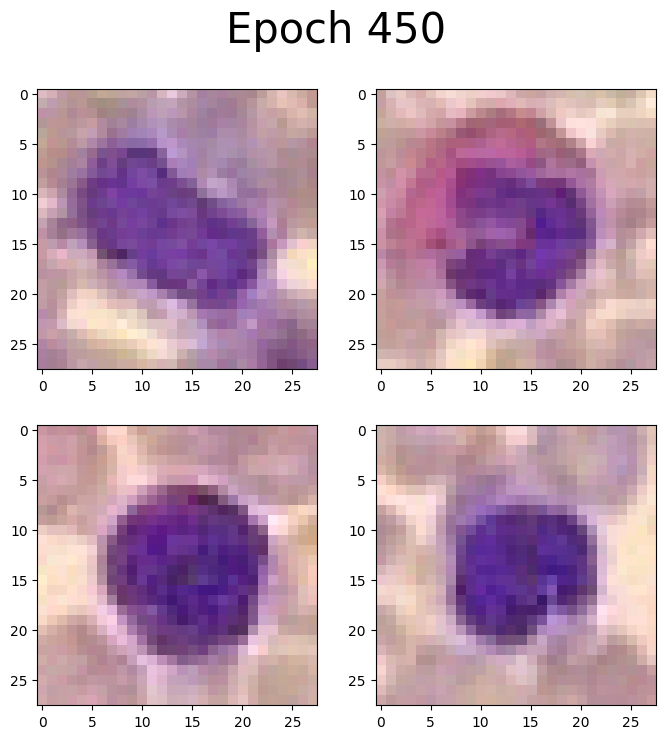

Epoch 450: Loss = 0.0312
Epoch 451: Loss = 0.0304
Epoch 452: Loss = 0.0304
Epoch 453: Loss = 0.0306
Epoch 454: Loss = 0.0310
Epoch 455: Loss = 0.0305
Epoch 456: Loss = 0.0309
Epoch 457: Loss = 0.0308
Epoch 458: Loss = 0.0313
Epoch 459: Loss = 0.0304
Epoch 460: Loss = 0.0308
Epoch 461: Loss = 0.0310
Epoch 462: Loss = 0.0305
Epoch 463: Loss = 0.0321
Epoch 464: Loss = 0.0307
Epoch 465: Loss = 0.0306
Epoch 466: Loss = 0.0314
Epoch 467: Loss = 0.0305
Epoch 468: Loss = 0.0316
Epoch 469: Loss = 0.0308
Epoch 470: Loss = 0.0308
Epoch 471: Loss = 0.0311
Epoch 472: Loss = 0.0307
Epoch 473: Loss = 0.0304
Epoch 474: Loss = 0.0306


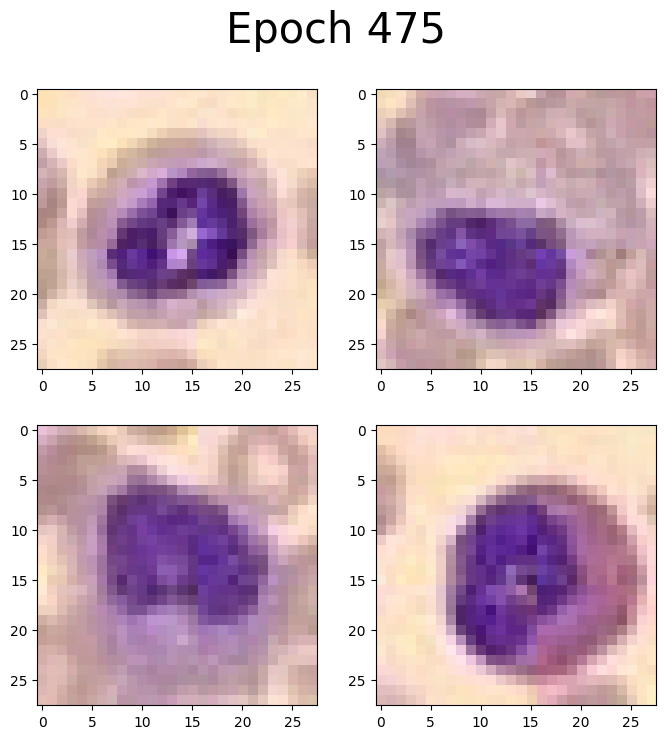

Epoch 475: Loss = 0.0315
Epoch 476: Loss = 0.0313
Epoch 477: Loss = 0.0302
Epoch 478: Loss = 0.0308
Epoch 479: Loss = 0.0304
Epoch 480: Loss = 0.0303
Epoch 481: Loss = 0.0313
Epoch 482: Loss = 0.0321
Epoch 483: Loss = 0.0310
Epoch 484: Loss = 0.0301
Epoch 485: Loss = 0.0304
Epoch 486: Loss = 0.0309
Epoch 487: Loss = 0.0306
Epoch 488: Loss = 0.0314
Epoch 489: Loss = 0.0304
Epoch 490: Loss = 0.0307
Epoch 491: Loss = 0.0311
Epoch 492: Loss = 0.0302
Epoch 493: Loss = 0.0304
Epoch 494: Loss = 0.0309
Epoch 495: Loss = 0.0300
Epoch 496: Loss = 0.0307
Epoch 497: Loss = 0.0308
Epoch 498: Loss = 0.0310
Epoch 499: Loss = 0.0314


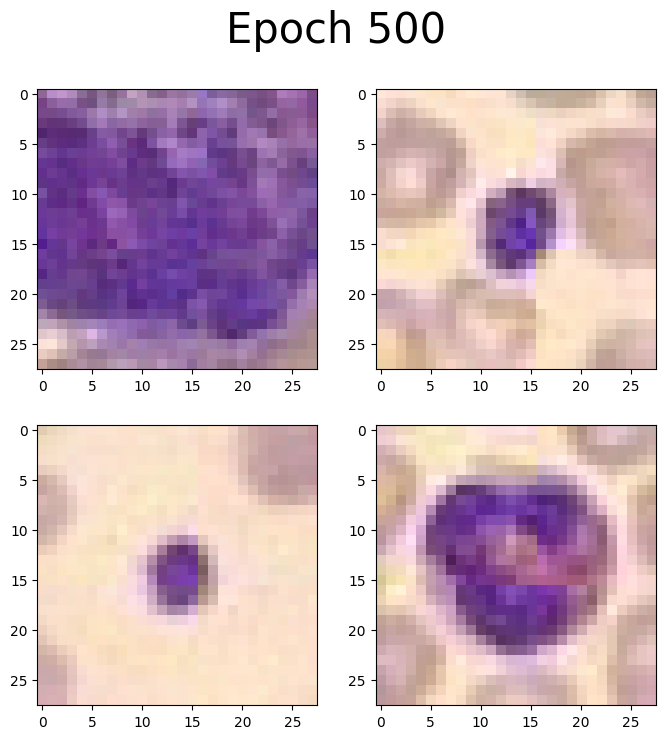

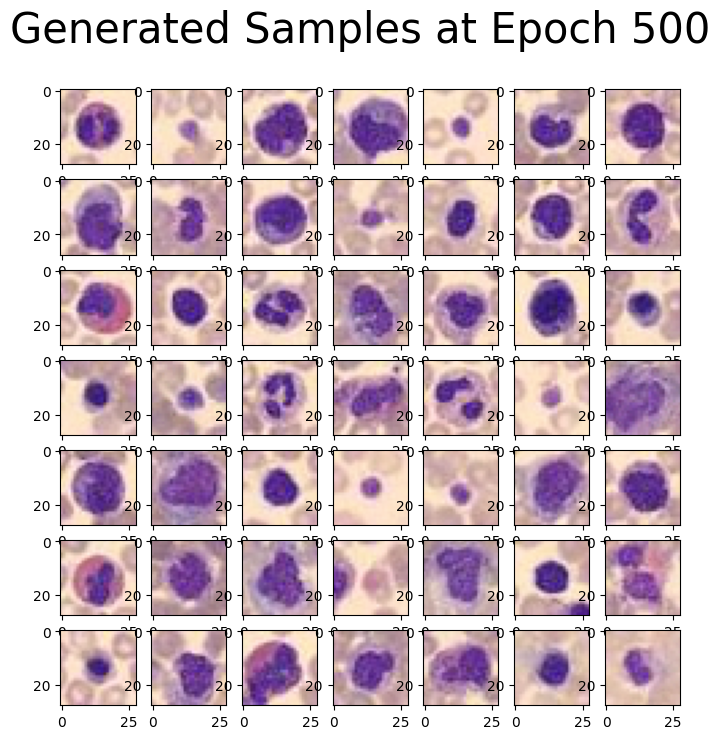

Epoch 500: Loss = 0.0301


In [7]:
# Training
training_loop(ddpm, dataloader, n_epochs, optim=torch.optim.Adam(ddpm.parameters(), lr), device=device, display=True)

Generating new images


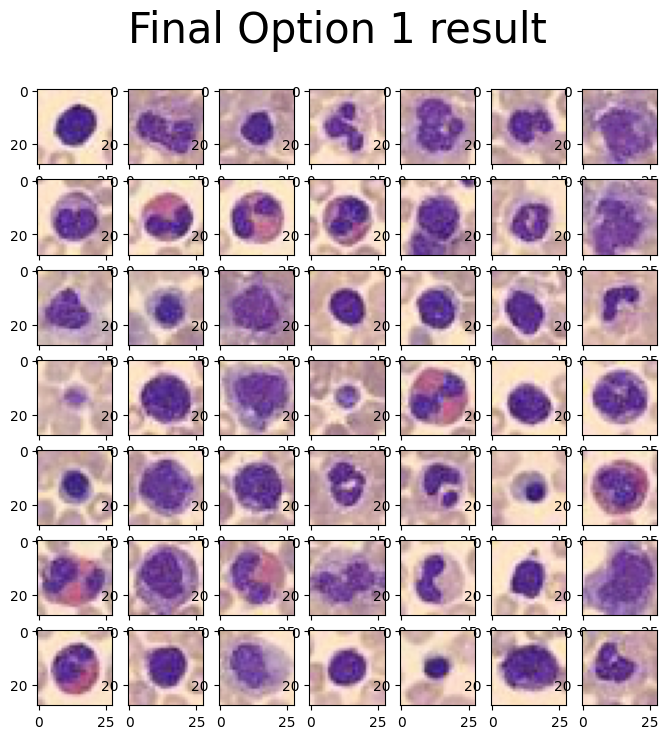

In [ ]:
print("Generating new images")
generated = generate_new_images(
        ddpm,
        option = 2,
        n_samples= 49,
        device=device,
    )
show_images(generated, "Final Option 1 result")

import torchvision.utils as vutils

grid = vutils.make_grid(generated, nrow=8, normalize=True, scale_each=True)

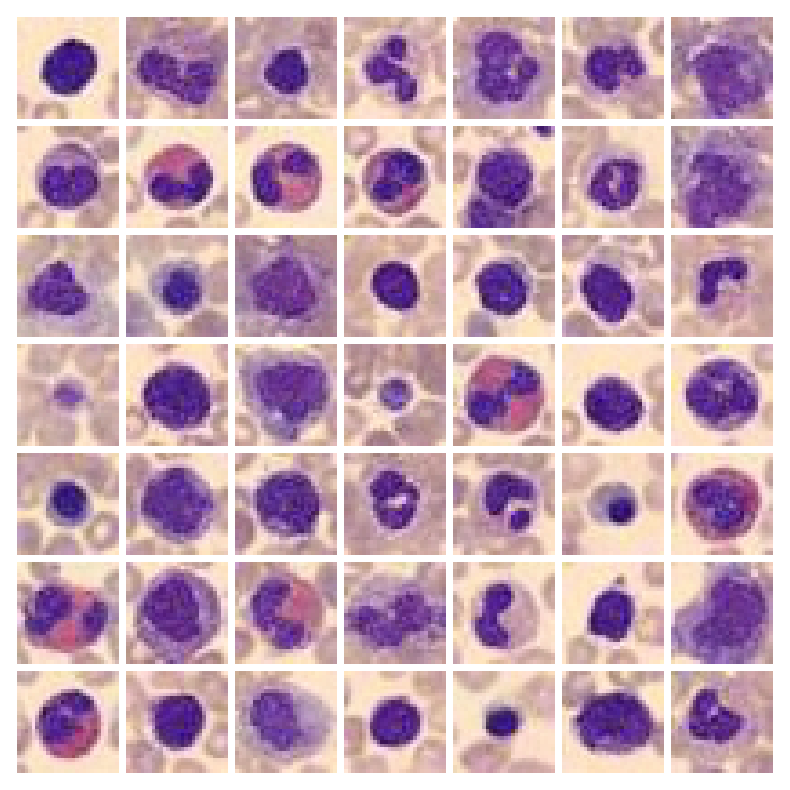

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.utils as vutils


def show_generated_images(images):

    grid = vutils.make_grid(images, nrow=7, padding=2, normalize=True, pad_value=1.0)
    
    
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
show_generated_images(generated)

In [19]:
N_EVAL_SAMPLES = 10000

In [20]:
from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
# **************************************
# Wrapper to use pytorch_fid's fid_score() with in-memory images
import pytorch_fid_wrapper as pfw

def get_fid(synthetic_samples):
    random_sampler = RandomSampler(
                dataloader, num_samples=N_EVAL_SAMPLES)

    eval_dataloader = DataLoader(
                dataset=dataset, batch_size=128, sampler=random_sampler)
    eval_tensor = torch.cat(
                [batch[0] for batch in eval_dataloader], dim=0)


    # 4. Compute Frechet Inception Distance (FID) between real and synthetic
    pfw.set_config(batch_size=10, dims=2048, device="cuda" if torch.cuda.is_available() else "cpu")
    # print(f"Real samples shape: {eval_tensor.shape}")
    # print(f"Fake samples shape: {synthetic_samples.shape}"
    fid = pfw.fid(fake_images=synthetic_samples,
                real_images=eval_tensor)
    print(f"FID:{fid}")
    
    return fid


In [21]:
import random

import numpy as np


EVAL_SEEDS = [100, 200, 300, 400, 500]


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)


fid_scores = []

for seed in EVAL_SEEDS:
    set_seed(seed)
    synthetic_samples = ddpm.generate_synthetic_samples(
        n_to_generate=N_EVAL_SAMPLES,
        batch_size=128,
        n_steps=n_steps
    )
    fid_score = get_fid(synthetic_samples)
    print(f"FID score for seed {seed}: {fid_score}")
    fid_scores.append(fid_score)
    
print(f"Average FID score: {np.mean(fid_scores)}")
print(f"Standard deviation of FID scores: {np.std(fid_scores)}")
print("Evaluation completed.")

Generating 10000 samples in 79 batches using 500 steps...
Using steps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207

KeyboardInterrupt: 